In [25]:
#import all necessary packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
import mygrads as mg
#import Ngl
#import Nio
#import fiona
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
from clim680_function import xyticks
import pymannkendall as mk
from matplotlib.cm import get_cmap

In [2]:
f='/project/xprecip/merra2_ncfiles/slp/*.nc'
DS_slp=xr.open_mfdataset(f,combine='nested',concat_dim='time')
DS_slp

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 374736)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2021-09-30T23:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(24, 66, 120), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 18...
    Comment:                           GMAO filename: d5124_m2_jan79.inst1_2d...
    Filename:                          MERRA2_100.inst1_2d_asm_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [3]:
sorted=DS_slp.sortby('time')

In [4]:
winter_selected=sorted.isel(time=sorted.time.dt.season.isin(['DJF']))
winter_selected

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 92400)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T23:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(24, 66, 120), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 18...
    Comment:                           GMAO filename: d5124_m2_jan79.inst1_2d...
    Filename:                          MERRA2_100.inst1_2d_asm_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [5]:
slp_sixhourly=winter_selected.resample(time='6H').mean(dim='time')

In [6]:
slp_sixhourly.to_netcdf('/project/xprecip/merra2_ncfiles/slp/slp_sixhourly.nc')
slp_sixhourly

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 61600)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 dask.array<chunksize=(1, 66, 120), meta=np.ndarray>

In [8]:
### Load in the new resampled 6 hourly file
f='/project/xprecip/merra2_ncfiles/slp/slp_sixhourly.nc'
DS_slp_6hr=xr.open_dataset(f)
DS_slp_6hr

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 61600)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 ...

In [9]:
slp_6hr=DS_slp_6hr['SLP']
slp_6hr

<xarray.DataArray 'SLP' (time: 61600, lat: 66, lon: 120)>
[487872000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [10]:
daily_climo_slp=slp_6hr.groupby('time.dayofyear').mean(dim='time')
daily_climo_slp

<xarray.DataArray 'SLP' (dayofyear: 366, lat: 66, lon: 120)>
array([[[101834.45 , 101831.42 , 101827.43 , ..., 101922.02 ,
         101920.86 , 101919.67 ],
        [101864.93 , 101860.836, 101856.875, ..., 101953.195,
         101951.76 , 101949.95 ],
        [101894.49 , 101889.74 , 101885.45 , ..., 101983.85 ,
         101982.055, 101980.49 ],
        ...,
        [101182.836, 101149.05 , 101098.805, ..., 100419.95 ,
         100367.62 , 100318.79 ],
        [101144.945, 101121.21 , 101122.664, ..., 100365.74 ,
         100310.59 , 100262.164],
        [101069.625, 101099.195, 101149.6  , ..., 100308.12 ,
         100251.555, 100202.305]],

       [[101807.83 , 101806.83 , 101805.28 , ..., 101903.29 ,
         101902.38 , 101901.65 ],
        [101835.51 , 101833.86 , 101832.195, ..., 101934.35 ,
         101933.49 , 101932.45 ],
        [101861.99 , 101859.88 , 101858.305, ..., 101964.62 ,
         101963.41 , 101962.22 ],
...
        [101296.46 , 101261.8  , 101220.43 , ..., 100357.52 ,
         100297.234, 100236.57 ],
        [101264.87 , 101248.59 , 101254.86 , ..., 100332.7  ,
         100270.13 , 100208.984],
        [101201.414, 101243.63 , 101302.91 , ..., 100300.94 ,
         100236.914, 100175.57 ]],

       [[101919.08 , 101914.05 , 101908.85 , ..., 101838.42 ,
         101840.03 , 101840.84 ],
        [101954.09 , 101948.66 , 101942.28 , ..., 101866.   ,
         101866.65 , 101866.47 ],
        [101985.6  , 101979.8  , 101973.695, ..., 101892.73 ,
         101892.18 , 101892.18 ],
        ...,
        [101322.3  , 101289.5  , 101268.1  , ..., 100048.34 ,
         100035.07 , 100029.22 ],
        [101318.67 , 101307.375, 101309.3  , ..., 100011.53 ,
          99996.5  ,  99985.3  ],
        [101259.66 , 101319.49 , 101387.65 , ...,  99980.23 ,
          99956.625,  99939.2  ]]], dtype=float32)
Coordinates:
  * lon        (lon) float64 -127.5 -126.9 -126.2 ... -54.38 -53.75 -53.12
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [11]:
dc_slp=daily_climo_slp.sel(lat=39,lon=-77,method='nearest')
dc_slp

<xarray.DataArray 'SLP' (dayofyear: 366)>
array([102097.01 , 102108.21 , 102009.47 , 101825.33 , 101841.78 ,
       101885.47 , 101852.625, 101964.51 , 102087.28 , 102219.14 ,
       102170.42 , 101934.91 , 101927.48 , 102017.74 , 102034.01 ,
       102066.664, 102067.53 , 101883.85 , 101868.03 , 101738.05 ,
       102059.805, 102177.55 , 101840.4  , 101616.836, 101795.45 ,
       101940.93 , 102029.52 , 101992.86 , 102045.86 , 101930.99 ,
       101929.836, 101989.28 , 101917.59 , 101973.86 , 101940.36 ,
       101975.125, 102077.17 , 101899.35 , 101924.234, 102061.78 ,
       102049.02 , 101877.65 , 101885.42 , 101986.945, 101843.734,
       101917.01 , 101917.49 , 102049.52 , 102035.64 , 102029.67 ,
       102031.71 , 101879.125, 101870.26 , 101708.35 , 101707.03 ,
       101761.266, 101984.195, 101916.02 , 101858.64 , 101657.09 ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 101943.65 ,
       101801.12 , 101875.05 , 101961.13 , 102016.8  , 101897.164,
       102015.91 , 102182.73 , 102070.836, 101984.41 , 101877.48 ,
       101890.77 , 101919.664, 101878.2  , 101914.25 , 101951.62 ,
       102108.79 , 101910.19 , 102019.98 , 102113.52 , 102147.89 ,
       102081.69 , 101940.   , 102002.96 , 101878.836, 101981.16 ,
       102310.016, 102161.29 , 101939.664, 101994.79 , 102132.07 ,
       101968.84 ], dtype=float32)
Coordinates:
    lon        float64 -76.88
    lat        float64 39.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

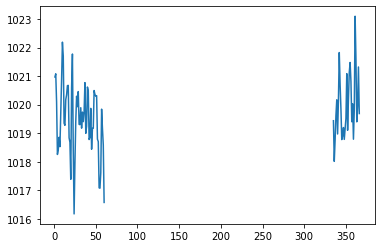

In [27]:
plt.plot(dc_slp['dayofyear'],(dc_slp/100.))

In [13]:
min_6hrly=slp_6hr.groupby('time.hour').min(dim='time')
min_6hrly

<xarray.DataArray 'SLP' (hour: 4, lat: 66, lon: 120)>
array([[[100641.875, 100577.99 , 100604.73 , ..., 100329.34 ,
         100316.94 , 100309.19 ],
        [100584.29 , 100538.41 , 100500.54 , ..., 100249.16 ,
         100272.9  , 100257.56 ],
        [100533.836, 100575.28 , 100523.79 , ..., 100174.91 ,
         100222.94 , 100200.81 ],
        ...,
        [ 96616.5  ,  96687.164,  96686.   , ...,  94383.54 ,
          94092.04 ,  93846.375],
        [ 96680.336,  96724.664,  96744.164, ...,  94303.04 ,
          94020.71 ,  93772.375],
        [ 96728.336,  96761.836,  96804.   , ...,  94343.21 ,
          94077.04 ,  93829.04 ]],

       [[100689.586, 100685.96 , 100726.54 , ..., 100030.02 ,
         100102.27 , 100191.94 ],
        [100655.98 , 100656.75 , 100672.35 , ...,  99935.69 ,
         100021.02 , 100125.23 ],
        [100588.06 , 100631.31 , 100634.73 , ...,  99849.4  ,
          99947.65 , 100070.31 ],
...
        [ 96040.91 ,  95930.91 ,  95766.41 , ...,  94892.02 ,
          94697.35 ,  94533.02 ],
        [ 95828.24 ,  95694.41 ,  95653.57 , ...,  95000.69 ,
          94843.52 ,  94724.35 ],
        [ 95621.91 ,  95548.57 ,  95528.91 , ...,  95108.85 ,
          94990.52 ,  94886.35 ]],

       [[100678.96 , 100683.29 , 100694.96 , ..., 100105.88 ,
         100054.72 , 100022.84 ],
        [100643.125, 100648.04 , 100659.96 , ..., 100042.51 ,
          99959.38 ,  99903.13 ],
        [100598.74 , 100614.54 , 100626.125, ...,  99973.055,
          99872.26 ,  99789.09 ],
        ...,
        [ 96918.195,  97004.695,  97024.03 , ...,  95634.91 ,
          95305.15 ,  95015.48 ],
        [ 97089.37 ,  97184.695,  97253.53 , ...,  95591.48 ,
          95302.65 ,  95042.48 ],
        [ 97319.37 ,  97400.09 ,  97311.43 , ...,  95401.74 ,
          95273.74 ,  95187.24 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
  * hour     (hour) int64 0 6 12 18

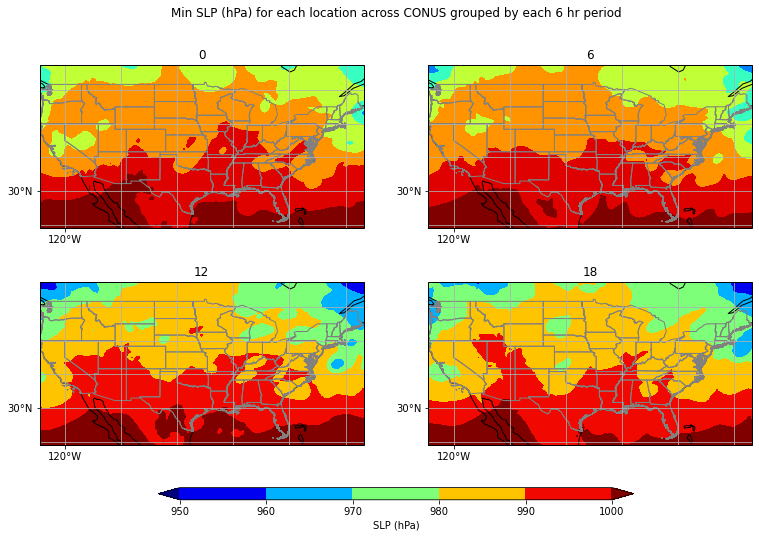

In [26]:
# Define the figure and each axis for the 2 rows and 2 columns
us_shapes = list(shpreader.Reader("/scratch/areed29/gadm36_USA_shp/gadm36_USA_1.shp").geometries())

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
#clevs=np.arange(-1,1.1,0.1)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()
#Loop over all of the seasons and plot
for i,hour in enumerate(min_6hrly['hour']):

        # Select the hour
        data=(min_6hrly/100.).sel(hour=hour)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=min_6hrly['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,min_6hrly['lat'],data,
                          transform = ccrs.PlateCarree(),cmap=get_cmap("jet")
                        ,extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the lag
        axs[i].set_title(hour.values)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        #axs[i].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        #axs[i].stock_img()
        #axs[i].add_feature(cartopy.feature.OCEAN)

        axs[i].gridlines()
        axs[i].set_extent([-124.5,-66.8,23.486,49])
        axs[i].add_geometries(us_shapes, ccrs.PlateCarree(), edgecolor='gray',
                  facecolor='none')


# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='SLP (hPa)')
plt.suptitle('Min SLP (hPa) for each location across CONUS grouped by each 6 hr period')
plt.savefig('/homes/areed29/CLIM751/min_slp_conus_6hrly.png')

In [14]:
time_min_slp=slp_6hr.min(dim='time')
time_min_slp

<xarray.DataArray 'SLP' (lat: 66, lon: 120)>
array([[100641.875, 100577.99 , 100604.73 , ..., 100030.02 , 100048.74 ,
        100022.84 ],
       [100584.29 , 100538.41 , 100500.54 , ...,  99935.69 ,  99935.12 ,
         99903.13 ],
       [100533.836, 100575.28 , 100523.79 , ...,  99843.03 ,  99819.945,
         99789.09 ],
       ...,
       [ 95315.54 ,  95327.54 ,  95271.21 , ...,  93878.48 ,  93611.81 ,
         93449.81 ],
       [ 95290.21 ,  95353.375,  95465.21 , ...,  94010.48 ,  93793.48 ,
         93618.81 ],
       [ 95402.54 ,  95514.04 ,  95528.91 , ...,  94226.15 ,  94062.81 ,
         93829.04 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

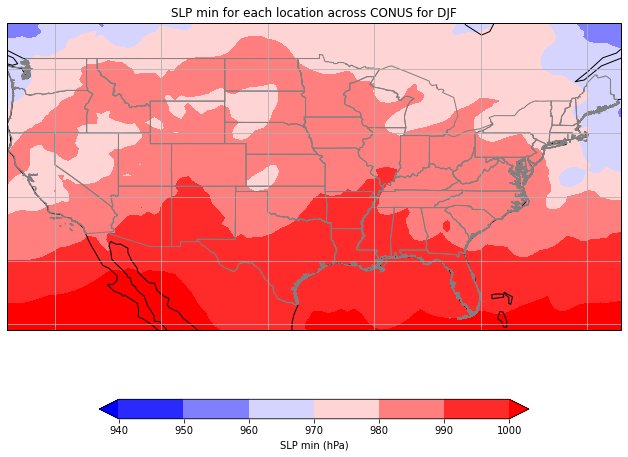

In [17]:
#clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=time_min_slp/100.

# Make a filled contour plot
cs=ax.contourf(time_min_slp['lon'],time_min_slp['lat'],
            data,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()
ax.set_extent([-124.5,-66.8,23.486,49])
us_shapes = list(shpreader.Reader("/scratch/areed29/gadm36_USA_shp/gadm36_USA_1.shp").geometries())
ax.add_geometries(us_shapes, ccrs.PlateCarree(), edgecolor='gray',
                  facecolor='none')

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='SLP min (hPa)')

# Add title
plt.title('SLP min for each location across CONUS for DJF')
plt.savefig('/homes/areed29/CLIM997/summer22_research/slp_min_conus_DJF')